This is my "sandbox" to play around with the BEA api. My plan is to use this for my regional cycle project. Below I explain how to use the BEA api (stuff has changed since I last messed around with it)

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import weightedcalcs as wc
import os
import geopandas as gpd # this is the main geopandas 

In [2]:
BEA_ID = "6BF79D8C-8042-4196-88DC-0E0C55B0C3B6"

After getting your key. [Here is some basic documentation](https://www.bea.gov/API/bea_web_service_api_user_guide.htm). Like a lot APIs, basic idea is to specify the URL in the proper way and it will return some output in a specified format. We can then convert the format (its .json) into a dataframe:



In [3]:
API_URL = "https://bea.gov/api/data?&"
API_URL = API_URL + "UserID=" + BEA_ID + "&method=GETDATASETLIST&ResultFormat=JSON&"
    
r = requests.get(API_URL)

In [4]:
print(r.json().keys())

print(r.json()['BEAAPI'].keys())

print(r.json()['BEAAPI']["Results"].keys())

dict_keys(['BEAAPI'])
dict_keys(['Request', 'Results'])
dict_keys(['Dataset'])


This then leads to the insight that the `.json()` is a bunch of dictionaries within the dictionaries and that by working through it we can find a "root dictionary" that can be converted into a usable DataFrame

In [5]:
df = pd.DataFrame(r.json()["BEAAPI"]["Results"]['Dataset'])

In [6]:
df

,DatasetDescription,DatasetName
0,The RegionalData dataset is obsolete. Please u...,RegionalData
1,Standard NIPA tables,NIPA
2,Standard NI underlying detail tables,NIUnderlyingDetail
3,Multinational Enterprises,MNE
4,Standard Fixed Assets tables,FixedAssets
5,International Transactions Accounts,ITA
6,International Investment Position,IIP
7,GDP by Industry,GDPbyIndustry
8,Regional Income data sets,RegionalIncome
9,Regional Product data sets,RegionalProduct


Then this gives us the different datasets that are available through the BEA api. Now below, I'm going to grab personal income at the county level. The documentation for grabing this is [here](https://www.bea.gov/API/bea_web_service_api_user_guide.htm)

This is how to find out the lines for individual tables. Table CA4 is of interest as it has the break down of personal income by types.

In [7]:
my_key = "https://bea.gov/api/data?&UserID=" + BEA_ID + "&"

data_set = "datasetname=RegionalIncome&"

method = "method=GetParameterValuesFiltered&"

dataset = "datasetname=RegionalIncome&"

linecode = "TargetParameter=LineCode&"

tablename = "TableName=CA4&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

API_URL = my_key + method + dataset + linecode + tablename + form

r = requests.get(API_URL)

r.json()["BEAAPI"]["Results"]


{'ParamValue': [{'Key': '10', 'Desc': '[CA4] Personal income'},
  {'Key': '11', 'Desc': '[CA4] Nonfarm personal income'},
  {'Key': '12', 'Desc': '[CA4] Farm income'},
  {'Key': '20', 'Desc': '[CA4] Population'},
  {'Key': '30', 'Desc': '[CA4] Per capita personal income'},
  {'Key': '35', 'Desc': '[CA4] Earnings by place of work'},
  {'Key': '36', 'Desc': '[CA4] Contributions for government social insurance'},
  {'Key': '37',
   'Desc': '[CA4] Employee and self-employed contributions for government social insurance'},
  {'Key': '38',
   'Desc': '[CA4] Employer contributions for government social insurance'},
  {'Key': '42', 'Desc': '[CA4] Adjustment for residence'},
  {'Key': '45', 'Desc': '[CA4] Net earnings by place of residence'},
  {'Key': '46', 'Desc': '[CA4] Dividends, interest, and rent'},
  {'Key': '47', 'Desc': '[CA4] Personal current transfer receipts'},
  {'Key': '50', 'Desc': '[CA4] Wages and salaries'},
  {'Key': '60', 'Desc': '[CA4] Supplements to wages and salaries'},
  

This then grabs the some of it as a deomonstration

In [8]:
my_key = "https://bea.gov/api/data?&UserID=" + BEA_ID + "&method=GetData&"

data_set = "datasetname=RegionalIncome&"

table_and_line_wages = "TableName=CA4&LineCode=010&"

year = "Year=" + "2000" + "&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

API_URL = my_key + data_set + table_and_line_wages + year + location + form

r = requests.get(API_URL)

df_income = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

In [9]:
df_income.head()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,thousands of dollars,CA4-10,8634847000,00000,United States,NaN,2000,3
1,thousands of dollars,CA4-10,108000944,01000,Alabama,NaN,2000,3
2,thousands of dollars,CA4-10,1036129,01001,"Autauga, AL",NaN,2000,3
3,thousands of dollars,CA4-10,3770707,01003,"Baldwin, AL",NaN,2000,3
4,thousands of dollars,CA4-10,547871,01005,"Barbour, AL",NaN,2000,3


---

Now what I want to do is to (for all years possible), grab the [personal per capital income](https://www.bea.gov/regional/#defs) and the population measure at the country level. There are several steps here. First, I construct a string of all the years I want. Then I pass the appropriate URL to the BEA. This took some time to figure this all out.

In [9]:
years = range(1969,2018)
years = list(years)

years = "".join(str(years))

years = years[1:-1]

In [10]:
years

'1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017'

This then grabs the per capita personal income data:

In [11]:
my_key = "https://bea.gov/api/data?&UserID=" + BEA_ID + "&method=GetData&"

data_set = "datasetname=RegionalIncome&"

table_and_line_income = "TableName=CA1&LineCode=3&"

table_and_line_population = "TableName=CA1&LineCode=2&"

year = "Year=" + years + "&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

In [12]:
API_URL = my_key + data_set + table_and_line_income + year + location + form

r = requests.get(API_URL)

df_income = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

In [13]:
df_income.head(15)

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,dollars,CA1-3,15459,00000,United States,NaN,1986,0
1,dollars,CA1-3,6312,00000,United States,NaN,1975,0
2,dollars,CA1-3,18653,00000,United States,NaN,1989,0
3,dollars,CA1-3,7494,00000,United States,NaN,1977,0
4,dollars,CA1-3,4196,00000,United States,NaN,1970,0
5,dollars,CA1-3,19591,00000,United States,NaN,1990,0
6,dollars,CA1-3,12652,00000,United States,NaN,1983,0
7,dollars,CA1-3,14719,00000,United States,NaN,1985,0
8,dollars,CA1-3,8338,00000,United States,NaN,1978,0
9,dollars,CA1-3,5352,00000,United States,NaN,1973,0


In [14]:
df_income.drop(['CL_UNIT', 'Code',"NoteRef", "UNIT_MULT"], axis=1, inplace = True)

#df["DataValue"].column = "IncomePC"

df_income.rename(columns={"DataValue":"IncomePC"}, inplace=True)

df_income.head()

,IncomePC,GeoFips,GeoName,TimePeriod
0,15459,00000,United States,1986
1,6312,00000,United States,1975
2,18653,00000,United States,1989
3,7494,00000,United States,1977
4,4196,00000,United States,1970


In [15]:
API_URL = my_key + data_set + table_and_line_population + year + location + form

r = requests.get(API_URL)

population = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

population.drop(['CL_UNIT', 'Code',"NoteRef", "UNIT_MULT", "GeoName"], axis=1, inplace = True)

#df["DataValue"].column = "IncomePC"

population.rename(columns={"DataValue":"Population"}, inplace=True)

population.head()

,Population,GeoFips,TimePeriod
0,222098244,00000,1978
1,272646925,00000,1997
2,246819222,00000,1989
3,282162411,00000,2000
4,244499004,00000,1988


In [33]:
combo = pd.merge(population, df_income,   # left df, right df
                 how='inner',      # Try the different options, inner, outer, left, right...what happens.
                 on=['GeoFips',"TimePeriod"],       # link with cntry
                 indicator=True)  # Tells us what happend

In [34]:
combo["TimePeriod"] = pd.to_datetime(combo["TimePeriod"], infer_datetime_format = True)

#combo.sort_values(by = "TimePeriod", inplace = True)

In [35]:
combo["county_fips"] = combo["GeoFips"].str[2:]
combo["state_fips"] = combo["GeoFips"].str[0:2]

In [36]:
combo.head()

,Population,GeoFips,TimePeriod,IncomePC,GeoName,_merge,county_fips,state_fips
0,222098244,00000,1978-01-01,8338,United States,both,000,00
1,272646925,00000,1997-01-01,25950,United States,both,000,00
2,246819222,00000,1989-01-01,18653,United States,both,000,00
3,282162411,00000,2000-01-01,30602,United States,both,000,00
4,244499004,00000,1988-01-01,17426,United States,both,000,00


In [37]:
combo = combo[combo.county_fips != "000"]

In [38]:
combo.set_index(["GeoFips","TimePeriod"],inplace = True)

In [39]:
combo.sort_index(level="GeoFips", inplace = True)

In [40]:
combo.index.shape

(150624,)

In [41]:
combo.Population.replace("(NA)", np.nan, inplace = True)
combo.Population = combo.Population.astype(float)

In [42]:
combo.IncomePC.replace("(NA)", np.nan, inplace = True)
combo.IncomePC = combo.IncomePC.astype(float)

In [43]:
combo.head()

Population  IncomePC      GeoName _merge county_fips  \
GeoFips TimePeriod                                                         
01001   1969-01-01     25166.0    2774.0  Autauga, AL   both         001   
        1970-01-01     24606.0    3147.0  Autauga, AL   both         001   
        1971-01-01     25508.0    3442.0  Autauga, AL   both         001   
        1972-01-01     27166.0    3672.0  Autauga, AL   both         001   
        1973-01-01     28463.0    4017.0  Autauga, AL   both         001   

                   state_fips  
GeoFips TimePeriod             
01001   1969-01-01         01  
        1970-01-01         01  
        1971-01-01         01  
        1972-01-01         01  
        1973-01-01         01

In [126]:
df.shape[0]

14

In [137]:
def time_diff(df):
    
    data = [100*(np.log(df["IncomePC"].iloc[-1]) - np.log(df["IncomePC"].iloc[0]))/df.shape[0],
            100*(np.log(df["Population"].iloc[-1]) - np.log(df["Population"].iloc[0]))/df.shape[0],
            np.log(df["IncomePC"].iloc[0]) , df["Population"].iloc[0] ]
    data = pd.DataFrame(data).T
    
    data.columns = ["income_growth", "population_growth", "income_level", "population_level"]
    
    return data

In [138]:
grp = combo.groupby("GeoFips")

grp.get_group("01001")

test = grp.apply(time_diff)

(4, 7)

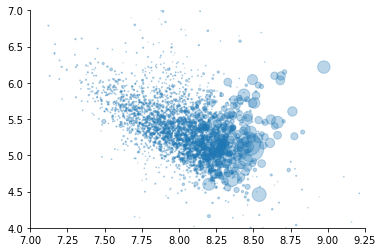

In [139]:
fig, ax = plt.subplots()

ax.scatter(test.income_level, test.income_growth, alpha = 0.30,
           s = 0.0001*test.population_level )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim(7,9.25)
ax.set_ylim(4,7)

In [118]:
test.corr()

,income_growth,income_level,population_level
income_growth,1.000000,-0.606591,-0.034234
income_level,-0.606591,1.000000,0.210992
population_level,-0.034234,0.210992,1.000000


In [44]:
combo.dropna(inplace=True)
grp = combo.groupby(["TimePeriod"])

In [45]:
calc = wc.Calculator("Population")

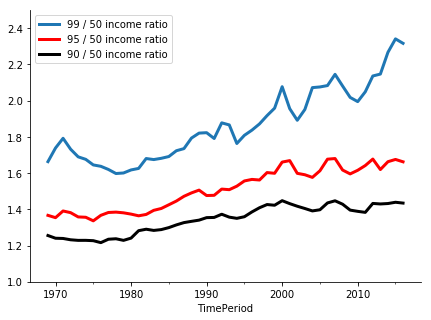

In [49]:
rich_poor_99 = (calc.quantile(grp, "IncomePC", 0.99)/calc.quantile(grp, "IncomePC", 0.50))
rich_poor_95 = (calc.quantile(grp, "IncomePC", 0.95)/calc.quantile(grp, "IncomePC", 0.50))
rich_poor_90 = (calc.quantile(grp, "IncomePC", 0.90)/calc.quantile(grp, "IncomePC", 0.50))

fig, ax  = plt.subplots(figsize = (7,5))

rich_poor_99.plot(ax = ax, lw = 3, label = "99 / 50 income ratio" )

rich_poor_95.plot(ax = ax, lw = 3, color = "red", label = "95 / 50 income ratio" )

rich_poor_90.plot(ax = ax, lw = 3, color = "black", label = "90 / 50 income ratio" )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim(1.0,2.5)

plt.legend()
plt.show()

In [31]:
year1 = "1969-01-01"
year2 = "1980-01-01"

us_counties69 = combo.xs(year1, level='TimePeriod').dropna()

us_counties69.rename(columns = {"IncomePC": "IncomePC"+ year1}, inplace=True)

mean69 = calc.median(us_counties69, "IncomePC"+ year1)

us_counties15 = combo.xs(year2, level='TimePeriod').dropna()

us_counties15.rename(columns = {"IncomePC": "IncomePC"+ year2}, inplace=True)

mean15 = calc.median(us_counties15, "IncomePC"+ year2)

In [32]:
print(mean15)

print(mean69)

10041.0
3892.0


In [36]:
cwd = os.getcwd()

regions_shape = '''C:\\data_bootcamp_spring_2018\\week13\\shape_files\\UScounties\\cb_2017_us_county_500k.shx'''

In [37]:
regions_shape

'C:\\data_bootcamp_spring_2018\\week13\\shape_files\\UScounties\\cb_2017_us_county_500k.shx'

In [38]:
us_map = gpd.read_file(regions_shape)

OSError: no such file or directory: 'C:\\data_bootcamp_spring_2018\\week13\\shape_files\\UScounties\\cb_2017_us_county_500k.shx'

In [ ]:
us_map.head()

us_map["GeoFips"] = us_map["STATEFP"] + us_map["COUNTYFP"]

us_map.set_index("STATEFP", inplace = True)

us_map.drop(["02","03","15","43","14","79","78","72","69","60","66"], inplace = True)

In [ ]:
us_counties69.columns

In [ ]:
us_map  = us_map.merge(us_counties69, on='GeoFips', how = "left")

us_map  = us_map.merge(us_counties15, on='GeoFips', how = "left")

us_map.head()


In [ ]:
us_map["log_income"+ year1] = np.log(us_map["IncomePC"+ year1] / mean69) 

us_map["log_income"+ year2] = np.log(us_map["IncomePC"+ year2] / mean15) 

us_map.head()

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (10,15))

# First create the map for the urban share

us_map.plot(ax = ax[0], edgecolor='tab:grey', column="log_income"+ year1, cmap='RdBu_r', alpha = 0.5)



us_map.plot(ax = ax[1], edgecolor='tab:grey', column="log_income"+ year2, cmap='RdBu_r', alpha = 0.5)

ax_length = range(0,2)

for var in ax_length:
    ax[var].spines["right"].set_visible(False)
    ax[var].spines["top"].set_visible(False)


###################################################

plt.show()

---

In [ ]:
us_map.head()

In [ ]:
df.dtypes

In [ ]:
df["TimePeriod"] = pd.to_datetime(df["TimePeriod"], infer_datetime_format = True)

In [ ]:
df.sort_values(by = "TimePeriod", inplace = True)


In [ ]:
df.head()

In [ ]:
grp = df.groupby("GeoFips")

In [ ]:
def log_diff_income(df):
    df["growth"] = np.log(df.DataValue).diff() / 46
    
    return df

In [ ]:
transform_dict = {"DataValue": ["first","last", lambda x: np.diff(np.log(x))/46]}

new_df = grp.agg(transform_dict)

In [ ]:
new_df["DataValue"]["last"].corr(new_df["DataValue"]["<lambda>"])

In [ ]:
test =  new_df.diff(axis = 1).toseries

In [ ]:
np.diff?

In [ ]:
grp = df.groupby("GeoFips")
grp.get_group("44007").TimePeriod.diff()

In [ ]:
grp.get_group("44007").TimePeriod.diff

In [ ]:
grp.get_group("44007").sort_value

In [ ]:
grp.get_group("44007").sort_values

In [ ]:
new_df.sort_values?

In [ ]:
new_df.growth.corr(new_df.loc["1969-01-01"].DataValue)

In [ ]:
new_df.set_index("TimePeriod", inplace = True)

In [ ]:
df.diff?